In [14]:
#Imports

import MDAnalysis as mda
from MDAnalysis.analysis import contacts
from MDAnalysis.analysis import distances
import statistics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from pathlib import Path
from scipy.stats import binned_statistic

In [ ]:
#Calculate distances

compounds_AB = ["DMNFH", "DMNFQ", "HAQOH", "HAQO", "MNDOL", "MND", "UBQH", "UBQ0", "XQH2", "XQ"]
replicates = ["rep_1", "rep_2", "rep_3", "rep_4", "rep_5"]
comps=[]
compounds_replicates = []
names_quinones = []
for compound in compounds_AB:
    print(compound)
    reps = []
    for replicate in replicates:
        compoundpath = Path(f"{compound}/{replicate}")    
        if not compoundpath.is_dir():
            continue
        print(replicate)
        compounds_replicates.append(f"{compound}, {replicate}")
        u = mda.Universe(str(compoundpath/"equilibration.gro"), str(compoundpath/"traj_comp.xtc"))
        ISOALO = u.select_atoms("resname FAD and name B14 B15 B16 B17 B18 B19 B20 B21 B22")
        all_quinones = u.select_atoms(f"resname {compound}")
        n_compounds = len(all_quinones.residues)
        n_beads = int(len(all_quinones)/n_compounds)
        traj_contacts= []
        names_quinones.append(all_quinones.residues.resids)
        for ts in tqdm(u.trajectory):
            dists = distances.distance_array(all_quinones.positions, ISOALO.positions)
            new_dists = dists.reshape(20,n_beads,-1)
            ctx = new_dists < 6
            for_frame = np.any(ctx, axis=(1,2))
            traj_contacts.append(for_frame)
        reps.append(traj_contacts)
    comps.append(reps)

In [16]:
#To save our results

pd.to_pickle(comps, "comps.obj")

In [ ]:
#Residence times

compounds_residence_times = {}
pb = tqdm(total=len(compounds_AB)*len(replicates))
for compound_data, compound_name in zip(comps, compounds_AB):
    reps_residence_times = []
    for rep in compound_data:
        pb.update()
        contacts = np.array(rep).T.astype(int).copy()
        max_index = contacts.shape[1]
        events = np.diff(contacts, axis=1, prepend=0, append=0)
        event_times = events.nonzero()[1]
        #Label first and last frames events in a way that they yield negative residence times
        event_times[event_times == 0] = max_index + 1
        event_times[event_times == max_index] = -1
        residence_times = np.diff(event_times)[::2]
        residence_times = residence_times[residence_times > 0]
        reps_residence_times.append(residence_times)
    compounds_residence_times[compound_name] = np.concatenate(reps_residence_times)

In [19]:
#To read our results

comps = pd.read_pickle("comps.obj")

In [20]:
#Getting the sum of the several trajectories of each replicate for each substrate

sums_compound = []
for compound in comps:
    sums_replicates = 0
    for rep in compound:
        sum_rep = len(rep)
        sums_replicates+=sum_rep
    sums_compound.append(sums_replicates*u.trajectory.dt*1e-3)

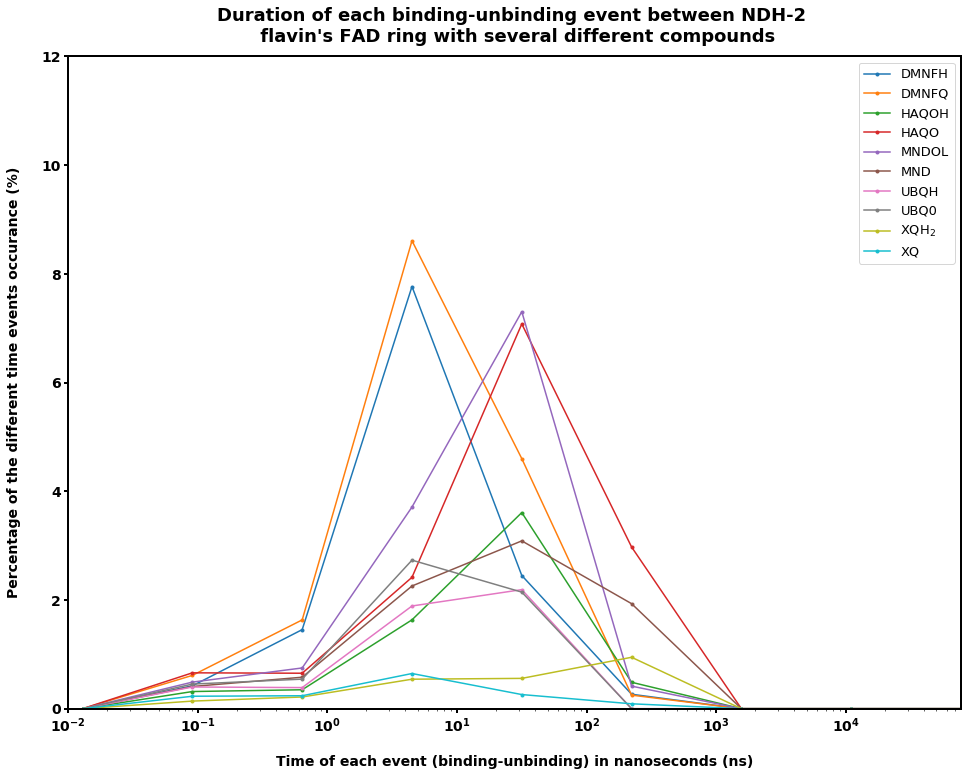


100%|██████████| 50/50 [00:17<00:00, 17.82it/s]

In [26]:
#Plot

names_of_compounds = ["DMNFH", "DMNFQ", "HAQOH", "HAQO", "MNDOL", "MND", "UBQH", "UBQ0", "XQH$_2$", "XQ"]
colors = ["#4bacc6", "#f39517", "#4bacc6", "#f39517", "#4bacc6", "#f39517", "#4bacc6", "#f39517", "#4bacc6", "#f39517"]

dt = u.trajectory.dt*1e-3
r = 2.1/0.9
n = 10
minimum = np.log(0.99*dt)
maximum = np.log(0.99*dt*r**(n-1))
bins = np.logspace(minimum,maximum,n)
left_edges = bins[:-1]
right_edges = bins[1:]
mid_point = (left_edges*right_edges)**0.5

fig, ax = plt.subplots()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(width=2, length=4)

for each_compound, total_time in zip(compounds_residence_times, sums_compound):
    rt = compounds_residence_times[each_compound]*u.trajectory.dt*1e-3
    h = (binned_statistic(rt, rt,statistic="sum",bins=bins)[0]/total_time)*100
    plt.plot(mid_point, h, ".-")
    
ax.set_yticklabels(np.arange(0, 14, 2), fontsize=14, weight='bold')    
ax.set_xticklabels(np.logspace(-2, 4.5, 8), fontsize=14, weight='bold')  
plt.xscale("log")
plt.legend(names_of_compounds, fontsize=13)
plt.ylabel('Percentage of the different time events occurance (%)', fontsize=14, fontweight = "bold", labelpad=20)
plt.xlabel("Time of each event (binding-unbinding) in nanoseconds (ns)", fontsize=14, fontweight = "bold", labelpad=20)
plt.title("Duration of each binding-unbinding event between NDH-2 \n flavin's FAD ring with several different compounds", fontsize=18, verticalalignment='center', fontweight = "bold", pad=30)
figure = plt.gcf() # get current figure
figure.set_size_inches(16, 12)
plt.xlim((0.01, mid_point[-1]))
plt.ylim((0, 12))
plt.savefig("Times_of_residence.svg", orientation="landscape", quality=95, dpi = 100, bbox_inches="tight")
plt.show()